In [1]:
import os.path

try:
    import pandas as pd
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !conda install pandas
    import pandas as pd
    
try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !conda install matplotlib
    import matplotlib.pyplot as plt
    
try:
    import gensim
    from gensim.models import Word2Vec
    from gensim.utils import simple_preprocess
    from gensim.parsing.porter import PorterStemmer
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --upgrade gensim
    import gensim
    from gensim.models import Word2Vec
    from gensim.utils import simple_preprocess
    from gensim.parsing.porter import PorterStemmer

try:
    from sklearn.metrics import classification_report
    from sklearn.model_selection import train_test_split
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !conda install scikit-learn
    from sklearn.metrics import classification_report
    from sklearn.model_selection import train_test_split    
    
try:
    import torch 
    import torch.optim as optim
    import torch.nn as nn
    import torch.nn.functional as F
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install torch torchvision torchaudio
    import torch 
    import torch.optim as optim
    import torch.nn as nn
    import torch.nn.functional as F
    



/home/cpb5867/anaconda3/envs/CNN/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
# DATA FOLDER AND WHERE WE SAVE STRIPPED DOWN DATASET
INPUT_FOLDER = "data/"
OUTPUT_FILE = INPUT_FOLDER + 'output_reviews_top.csv'

In [3]:
def load_yelp_orig_data(INPUT_FOLDER, OUTPUT_FILE):
    PATH_TO_YELP_REVIEWS = INPUT_FOLDER + 'yelp_academic_dataset_review.json'
    
    # READ ENTIRE FILE INTO A PYTHON ARRAY
    with open(PATH_TO_YELP_REVIEWS, 'r') as f:
        data = f.readlines()
        
    # REMOVE THE TRAILING "\n" FROM EACH LINE
    data = map(lambda x: x.rstrip(), data)
    
    # PYTHON REQUIRES COMMA SEPARATIONS SO DOES CSV 
    data_json_str = "[" + ','.join(data) + "]"
    
    # NOW, LOAD IT INTO PANDAS
    data_df = pd.read_json(data_json_str)
    
    # SAVE TOP 100K
    data_df.head(100000).to_csv(OUTPUT_FILE)

In [4]:
# ONLY PROCESS THE DATA IF WE DON'T HAVE IT YET
if not os.path.isfile(OUTPUT_FILE):
    load_yelp_orig_data(INPUT_FOLDER=INPUT_FOLDER, OUTPUT_FILE=OUTPUT_FILE)

# LOAD PROCESSED DATA
top_data_df = pd.read_csv(OUTPUT_FILE)

# PRINT COLUMNS FROM DATA FILE
print("Columns in the original dataset: \n")
print(top_data_df.columns)

Columns in the original dataset: 

Index(['Unnamed: 0', 'review_id', 'user_id', 'business_id', 'stars', 'useful',
       'funny', 'cool', 'text', 'date'],
      dtype='object')


In [5]:
# FUNCTION TO MAP STARS TO SENTIMENT
def map_sentiment(stars_received):
    if stars_received <= 2:
        return -1
    elif stars_received == 3:
        return 0
    else:
        return 1

Number of rows per star rating:
5    44392
4    25337
3    11362
1    10921
2     7988
Name: stars, dtype: int64


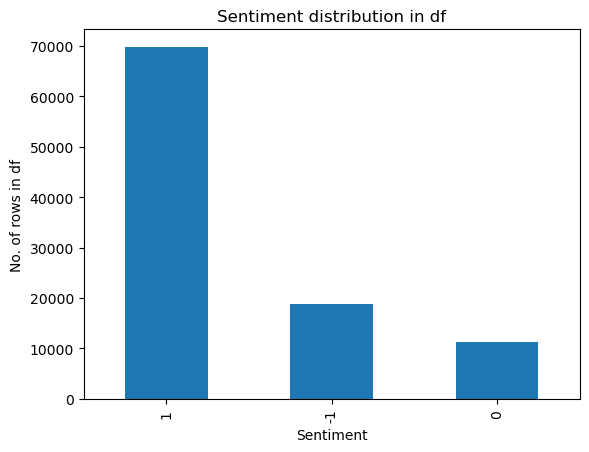

In [6]:
# PRINT TOTALS OF REVIEWS IN DATA
print("Number of rows per star rating:")
print(top_data_df['stars'].value_counts())

# MAPPING STARS TO SENTIMENT INTO THREE CATEGORIES
top_data_df['sentiment'] = [ map_sentiment(x) for x in top_data_df['stars']]

# PLOT THE SENTIMENT DISTRIBUTION
plt.figure()
pd.value_counts(top_data_df['sentiment']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

In [7]:
# FUNCTION TO RETRIEVE TOP NUMBER OF EACH CATEGORY
def get_top_data(top_data_df, top_n = 5000):
    top_data_df_positive = top_data_df[top_data_df['sentiment'] == 1].head(top_n)
    top_data_df_negative = top_data_df[top_data_df['sentiment'] == -1].head(top_n)
    top_data_df_neutral = top_data_df[top_data_df['sentiment'] == 0].head(top_n)
    
    # CREATE EVEN DATASET AND RETURN
    top_data_df_small = pd.concat([top_data_df_positive, top_data_df_negative, top_data_df_neutral])
    return top_data_df_small

In [8]:
# FUNCTION CALL TO GET THE TOP 10K FROM EACH SENTIMENT
top_data_df_small = get_top_data(top_data_df=top_data_df, top_n=10000)

# AFTER SELECTING TOP FEW SAMPLES OF EACH SENTIMENT SHOW METHOD WORKED
print("After segregating and taking equal number of rows for each sentiment:")
print(top_data_df_small['sentiment'].value_counts())

# SHOW THE TOP 10 REVIEWS, SHOULD ALL BE POSITIVE
top_data_df_small.head(10)

After segregating and taking equal number of rows for each sentiment:
 1    10000
-1    10000
 0    10000
Name: sentiment, dtype: int64


,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment
1,1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,1
3,3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,1
4,4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,1
6,6,6AxgBCNX_PNTOxmbRSwcKQ,r3zeYsv1XFBRA4dJpL78cw,gmjsEdUsKpj9Xxu6pdjH0g,5,0,2,0,Loved this tour! I grabbed a groupon and the p...,2015-01-03 23:21:18,1
7,7,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5,2,0,0,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16,1
10,10,rGQRf8UafX7OTlMNN19I8A,1WHRWwQmZOZDAhp2Qyny4g,uMvVYRgGNXf5boolA9HXTw,5,2,0,0,My experience with Shalimar was nothing but wo...,2015-06-21 14:48:06,1
11,11,l3Wk_mvAog6XANIuGQ9C7Q,ZbqSHbgCjzVAqaa7NKWn5A,EQ-TZ2eeD_E0BHuvoaeG5Q,4,0,0,0,"Locals recommended Milktooth, and it's an amaz...",2015-08-19 14:31:45,1
12,12,XW_LfMv0fV21l9c6xQd_lw,9OAtfnWag-ajVxRbUTGIyg,lj-E32x9_FA7GmUrBGBEWg,4,0,0,0,Love going here for happy hour or dinner! Gre...,2014-06-27 22:44:01,1
13,13,8JFGBuHMoiNDyfcxuWNtrA,smOvOajNG0lS4Pq7d8g4JQ,RZtGWDLCAtuipwaZ-UfjmQ,4,0,0,0,Good food--loved the gnocchi with marinara\nth...,2009-10-14 19:57:14,1
14,14,UBp0zWyH60Hmw6Fsasei7w,4Uh27DgGzsp6PqrH913giQ,otQS34_MymijPTdNBoBdCw,4,0,2,0,The bun makes the Sonoran Dog. It's like a snu...,2011-10-27 17:12:05,1


In [9]:
# TOKENIZE THE TEXT COLUMN TO GET THE NEW COLUMN 'tokenized_text'
# DEACC REMOVES ACCENT MARKS FROM THE TEXT
# SHOW RESULT OF TOP 10 TOKENIZED
top_data_df_small['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in top_data_df_small['text']] 
print(top_data_df_small['tokenized_text'].head(10))

1     [ve, taken, lot, of, spin, classes, over, the,...
3     [wow, yummy, different, delicious, our, favori...
4     [cute, interior, and, owner, gave, us, tour, o...
6     [loved, this, tour, grabbed, groupon, and, the...
7     [amazingly, amazing, wings, and, homemade, ble...
10    [my, experience, with, shalimar, was, nothing,...
11    [locals, recommended, milktooth, and, it, an, ...
12    [love, going, here, for, happy, hour, or, dinn...
13    [good, food, loved, the, gnocchi, with, marina...
14    [the, bun, makes, the, sonoran, dog, it, like,...
Name: tokenized_text, dtype: object


In [10]:
# WE CAN TRY LANCASTER AND SNOWBALL STEMMER AS WELL
# SNOWBALL IS PREFERRED
# LANCASTER IS SLOWER AND ROUGHLY EQUIVALENT TO PORTER
porter_stemmer = PorterStemmer()

# STEMMING REDUCES WORDS TO ROOT WORD, REMOVES SUFFIX & PREFIX
# GET THE stemmed_tokens
# SHOW RESULT OF TOP 10 STEMMED
top_data_df_small['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in top_data_df_small['tokenized_text'] ]
top_data_df_small['stemmed_tokens'].head(10)

1     [ve, taken, lot, of, spin, class, over, the, y...
3     [wow, yummi, differ, delici, our, favorit, is,...
4     [cute, interior, and, owner, gave, us, tour, o...
6     [love, thi, tour, grab, groupon, and, the, pri...
7     [amazingli, amaz, wing, and, homemad, bleu, ch...
10    [my, experi, with, shalimar, wa, noth, but, wo...
11    [local, recommend, milktooth, and, it, an, ama...
12    [love, go, here, for, happi, hour, or, dinner,...
13    [good, food, love, the, gnocchi, with, marinar...
14    [the, bun, make, the, sonoran, dog, it, like, ...
Name: stemmed_tokens, dtype: object

In [11]:
# TRAIN TEST SPLIT FUNCTION
def split_train_test(top_data_df_small, test_size=0.3, shuffle_state=True):
    
    # SPLIT USING TEST SIZE SPLIT AND SHUFFLE DATA AROUND SO IT IS NOT
    # SPLIT BY SENTIMENT
    # X WE HAVE ALL THE COLUMNS AND Y WE HAVE THE SENTIMENT OF THE COLUMNS
    X_train, X_test, Y_train, Y_test = train_test_split(top_data_df_small[['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text', 'useful', 'user_id', 'stemmed_tokens']], 
                                                        top_data_df_small['sentiment'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    
    print(type(X_train))
    print(type(Y_train))
    
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

In [12]:
# CALL THE train_test_split
# TRAIN AND TEST SENTIMENTS SHOULD BE EVENLY SPLIT
X_train, X_test, Y_train, Y_test = split_train_test(top_data_df_small)

Value counts for Train sentiments
 1    7036
-1    7008
 0    6956
Name: sentiment, dtype: int64
Value counts for Test sentiments
 0    3044
-1    2992
 1    2964
Name: sentiment, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
   index             business_id  cool                 date  funny  \
0  41964  h7zxeLAdUyAO6S6UzXJDwA     0  2018-05-20 02:15:46      0   
1  21237  ySXKjndttZjNy3kcqRqG3g     0  2015-12-20 20:30:12      0   
2  43742  9gObo5ltOMo6UgsaXaHPWA     0  2015-12-05 23:57:22      0   
3  35107  tvbFcYCEQWc76CUK-nBw8w     0  2018-07-27 08:09:21      0   
4   2960  Yv6HUVu7fRMnt_NtGdVQBw     0  2018-06-19 18:16:51      0   

                review_id  stars  \
0  xkcYjM_5w9rdSiN8_Qz_Tg      1   
1  XIYnB19-LAI_yzJfB2d7eQ      3   
2  Nm2XaG0sQ7p3LHoZG44cAg      1   
3  L8Ape_IoEHiMjgiufwCp8Q      3   
4  0uD1hdeUNPyfAaGOKpMMeQ      5   

                                                text  useful  \
0  Kids talking and being disru

In [13]:
# USE CUDA IF PRESENT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


In [14]:
# FUNCTION TO TRAIN WORD2VEC MODEL
def make_word2vec_model(top_data_df_small, INPUT_FOLDER, padding=True, sg=1, min_count=1, size=500, workers=3, window=3):
    if  padding:
        print(len(top_data_df_small))
        temp_df = pd.Series(top_data_df_small['stemmed_tokens']).values
        temp_df = list(temp_df)
        temp_df.append(['pad'])
        word2vec_file = INPUT_FOLDER + 'models/' + 'word2vec_' + str(size) + '_PAD.model'
    else:
        temp_df = top_data_df_small['stemmed_tokens']
        word2vec_file = INPUT_FOLDER + 'models/' + 'word2vec_' + str(size) + '.model'
    
    if os.path.isfile(word2vec_file):
        w2v_model = gensim.models.KeyedVectors.load(word2vec_file)
    else:
        w2v_model = Word2Vec(temp_df, min_count = min_count, vector_size = size, workers = workers, window = window, sg = sg)

    w2v_model.save(word2vec_file)
    return w2v_model, word2vec_file

In [15]:
size = 500
window = 3
min_count = 1
workers = 3
sg = 1

# TRAIN Word2vec MODEL
w2vmodel, word2vec_file = make_word2vec_model(top_data_df_small, INPUT_FOLDER, padding=True, sg=sg, min_count=min_count, size=size, workers=workers, window=window)

max_sen_len = top_data_df_small.stemmed_tokens.map(len).max()
padding_idx = w2vmodel.wv.index_to_key.index('pad')

30000


In [16]:
def make_word2vec_vector_cnnRELU(sentence, w2vmodel, max_sen_len, padding_idx, device):
    padded_X = [padding_idx for i in range(max_sen_len)]
    i = 0
    for word in sentence:
        if word not in w2vmodel.wv.index_to_key:
            padded_X[i] = 0
            print(word)
        else:
            # padded_X[i] = w2vmodel.wv.vocab[word].index
            padded_X[i] = w2vmodel.wv.index_to_key.index(word)
        i += 1
    return torch.tensor(padded_X, dtype=torch.long, device=device).view(1, -1)

In [17]:
# FUNCTION TO GET THE OUTPUT TENSOR
def make_target(label, device):
    if label == -1:
        return torch.tensor([0], dtype=torch.long, device=device)
    elif label == 0:
        return torch.tensor([1], dtype=torch.long, device=device)
    else:
        return torch.tensor([2], dtype=torch.long, device=device)

In [18]:
class CnnRELUTextClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes, INPUT_FOLDER, NUM_FILTERS, EMBEDDING_SIZE, window_sizes=(1,2,3,5)):
        super(CnnRELUTextClassifier, self).__init__()
        w2vmodel = gensim.models.KeyedVectors.load(INPUT_FOLDER + 'models/' + 'word2vec_500_PAD.model')
        weights = w2vmodel.wv
        # With pretrained embeddings
        # self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights.vectors), padding_idx=w2vmodel.wv.vocab['pad'].index)
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights.vectors), padding_idx=w2vmodel.wv.index_to_key.index('pad'))
        # Without pretrained embeddings
        # self.embedding = nn.Embedding(vocab_size, EMBEDDING_SIZE)

        self.convs = nn.ModuleList([
                                   nn.Conv2d(1, NUM_FILTERS, [window_size, EMBEDDING_SIZE], padding=(window_size - 1, 0))
                                   for window_size in window_sizes
        ])

        self.fc = nn.Linear(NUM_FILTERS * len(window_sizes), num_classes)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.embedding(x) # [B, T, E]

        # Apply a convolution + max_pool layer for each window size
        x = torch.unsqueeze(x, 1)
        xs = []
        for conv in self.convs:
            x2 = self.act(conv(x))
            x2 = torch.squeeze(x2, -1)
            x2 = F.max_pool1d(x2, x2.size(2))
            xs.append(x2)
        x = torch.cat(xs, 2)

        # FC
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        probs = F.softmax(logits, dim = 1)

        return probs

In [19]:
EMBEDDING_SIZE = 500
NUM_FILTERS = 10
NUM_CLASSES = 3
VOCAB_SIZE = len(w2vmodel.wv.index_to_key)

In [20]:
cnnRELU_model = CnnRELUTextClassifier(vocab_size=VOCAB_SIZE, num_classes=NUM_CLASSES, INPUT_FOLDER=INPUT_FOLDER, NUM_FILTERS=NUM_FILTERS, EMBEDDING_SIZE=EMBEDDING_SIZE)
cnnRELU_model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnnRELU_model.parameters(), lr=0.001)
num_epochs = 30

# Open the file for writing loss
loss_file_name = INPUT_FOLDER +  'plots/' + 'cnnRELU_class_big_loss_with_padding.csv'
f = open(loss_file_name,'w')
f.write('iter, loss')
f.write('\n')
losses = []
cnnRELU_model.train()

for epoch in range(num_epochs):
    print("Epoch " + str(epoch + 1))
    train_loss = 0
    for index, row in X_train.iterrows():
        # Clearing the accumulated gradients
        cnnRELU_model.zero_grad()

        # Make the bag of words vector for stemmed tokens 
        bow_vec = make_word2vec_vector_cnnRELU(row['stemmed_tokens'], w2vmodel, max_sen_len, padding_idx, device)
       
        # Forward pass to get output
        probs = cnnRELU_model(bow_vec)

        # Get the target label
        target = make_target(Y_train['sentiment'][index], device)

        # Calculate Loss: softmax --> cross entropy loss
        loss = loss_function(probs, target)
        train_loss += loss.item()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()


    # if index == 0:
    #     continue
    print("Epoch ran :"+ str(epoch+1))
    f.write(str((epoch+1)) + "," + str(train_loss / len(X_train)))
    f.write('\n')
    train_loss = 0

torch.save(cnnRELU_model, INPUT_FOLDER + 'cnnRELU_big_model_500_with_padding.pth')
f.close()

Epoch 1
Epoch ran :1
Epoch 2
Epoch ran :2
Epoch 3
Epoch ran :3
Epoch 4
Epoch ran :4
Epoch 5
Epoch ran :5
Epoch 6
Epoch ran :6
Epoch 7
Epoch ran :7
Epoch 8
Epoch ran :8
Epoch 9
Epoch ran :9
Epoch 10
Epoch ran :10
Epoch 11
Epoch ran :11
Epoch 12
Epoch ran :12
Epoch 13
Epoch ran :13
Epoch 14
Epoch ran :14
Epoch 15
Epoch ran :15
Epoch 16
Epoch ran :16
Epoch 17
Epoch ran :17
Epoch 18
Epoch ran :18
Epoch 19
Epoch ran :19
Epoch 20
Epoch ran :20
Epoch 21
Epoch ran :21
Epoch 22
Epoch ran :22
Epoch 23
Epoch ran :23
Epoch 24
Epoch ran :24
Epoch 25
Epoch ran :25
Epoch 26
Epoch ran :26
Epoch 27
Epoch ran :27
Epoch 28
Epoch ran :28
Epoch 29
Epoch ran :29
Epoch 30
Epoch ran :30


In [21]:
print("Input vector")
print(bow_vec.cpu().numpy())
print("Probs")
print(probs)
print(torch.argmax(probs, dim=1).cpu().numpy()[0])

Input vector
[[  34  288 2478    1  175   22    7  201    1  248   86  188   12   78
   997  272 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113
  1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113
  1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113
  1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113
  1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113
  1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113
  1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113
  1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113
  1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113
  1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113
  1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113
  1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113 1113
  1113 1113 1113 1113 1113 1113 1113 1113 1113 1113

In [22]:
# cnnRELU_model = torch.load(INPUT_FOLDER + 'cnnRELU_big_model_500_with_padding.pth')

Index(['iter', ' loss'], dtype='object')
              precision    recall  f1-score   support

           0       0.78      0.77      0.77      2992
           1       0.64      0.66      0.65      3044
           2       0.79      0.79      0.79      2964

    accuracy                           0.74      9000
   macro avg       0.74      0.74      0.74      9000
weighted avg       0.74      0.74      0.74      9000

Index(['iter', ' loss'], dtype='object')


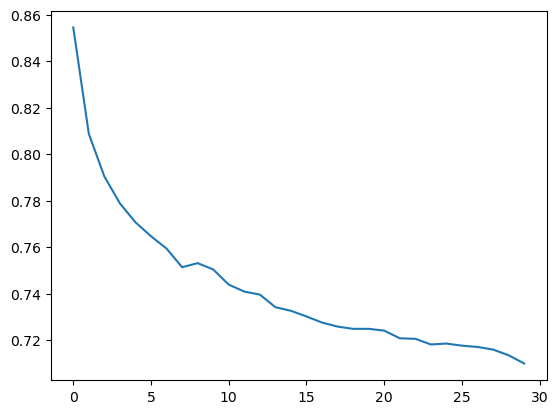

In [23]:
bow_cnnRELU_predictions = []
original_lables_cnnRELU_bow = []
cnnRELU_model.eval()
loss_df = pd.read_csv(INPUT_FOLDER + 'plots/' + 'cnnRELU_class_big_loss_with_padding.csv')
print(loss_df.columns)
# loss_df.plot('loss')

with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_word2vec_vector_cnnRELU(row['stemmed_tokens'], w2vmodel, max_sen_len, padding_idx, device)
        probs = cnnRELU_model(bow_vec)
        _, predicted = torch.max(probs.data, 1)
        bow_cnnRELU_predictions.append(predicted.cpu().numpy()[0])
        original_lables_cnnRELU_bow.append(make_target(Y_test['sentiment'][index], device).cpu().numpy()[0])

print(classification_report(original_lables_cnnRELU_bow,bow_cnnRELU_predictions))

loss_file_name = INPUT_FOLDER +  'plots/' + 'cnnRELU_class_big_loss_with_padding.csv'
loss_df = pd.read_csv(loss_file_name)
print(loss_df.columns)

plt_500_padding_30_epochs = loss_df[' loss'].plot()
fig = plt_500_padding_30_epochs.get_figure()
fig.savefig(INPUT_FOLDER +'plots/' + 'cnnrelu_loss_plt_500_padding_30_epochs.pdf')

In [24]:
pytorch_total_params = sum(p.numel() for p in cnnRELU_model.parameters() if p.requires_grad)
print(pytorch_total_params)

55163
